In [1]:
from pycocotools.coco import COCO

import numpy as np
from pandas import DataFrame as df

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

In [2]:
coco = COCO('/opt/ml/input/data/train.json')

loading annotations into memory...
Done (t=4.82s)
creating index...
index created!


# bbox EDA

In [3]:
image_ids = coco.getImgIds()

In [4]:
len(image_ids) # 총 이미지 사진의 개수

2617

In [5]:
image_id = image_ids[0]

In [6]:
# 이미지 한장의 정보 불러오기
image_infos = coco.loadImgs(image_id)[0]
print(image_infos)

{'license': 0, 'url': None, 'file_name': 'batch_01_vt/0003.jpg', 'height': 512, 'width': 512, 'date_captured': None, 'id': 0}


In [7]:
coco.loadImgs(image_id)

[{'license': 0,
  'url': None,
  'file_name': 'batch_01_vt/0003.jpg',
  'height': 512,
  'width': 512,
  'date_captured': None,
  'id': 0}]

In [8]:
# 0번 id에 대한 이미지 어노테이션 가져오기
ann_ids = coco.getAnnIds(imgIds =0)
anns = coco.loadAnns(ann_ids)
len(anns)

14

In [9]:
print(anns[0]['bbox'])

[128.2, 107.0, 381.3, 348.8]


In [10]:
print(type(anns[0]['segmentation']))

<class 'list'>


In [22]:
cat_ids = coco.getCatIds()
cat_ids

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [23]:
cats = coco.loadCats(cat_ids)

In [24]:
category_name_list = []

In [25]:
for cat in cats:
    category_name_list.append(cat['name'])

In [26]:
category_name_list 

['UNKNOWN',
 'General trash',
 'Paper',
 'Paper pack',
 'Metal',
 'Glass',
 'Plastic',
 'Styrofoam',
 'Plastic bag',
 'Battery',
 'Clothing']

In [27]:
# 이미지를 순회하며 카테고리마다 박스의 사이즈가 얼마나 되는지 조사

# 클래스 마다 박스 크기 저장
class_bbox_scale_list = []

for _ in range(11):
    class_bbox_scale_list.append([])

for image_id in image_ids:
    
    # 이미지에 대한 정보를 가져오기
    image_infos = coco.loadImgs(image_id)[0]
    image_id = image_infos['id'] # 이미지 아이디를 가져옴
    
    # annotation정보를 가져오기
    ann_ids = coco.getAnnIds(imgIds=image_id)
    anns = coco.loadAnns(ann_ids)
    
    # 카테고리 정보 가져오기
    for ann in anns:
        category_id = ann['category_id']
        bbox_information = ann['bbox']
        bbox_area = bbox_information[2] * bbox_information[3]
        class_bbox_scale_list[category_id].append(bbox_area)

In [28]:
# 이미지의 전체 크기
print(512 * 512)

262144


In [29]:
# 클래스마다의 bbox의 개수
class_bbox_count_list = []

for i in range(11):
    class_bbox_count_list.append(len(class_bbox_scale_list[i]))

In [30]:
class_bbox_count_list

[128, 2225, 7448, 527, 449, 488, 2472, 1074, 6114, 50, 141]

In [31]:
bbox_stat = df(data= {"category" : category_name_list, "count" : class_bbox_count_list},
               columns = ["category", "count"]
              )
bbox_stat.head()

,category,count
0,UNKNOWN,128
1,General trash,2225
2,Paper,7448
3,Paper pack,527
4,Metal,449


<AxesSubplot:xlabel='category', ylabel='count'>

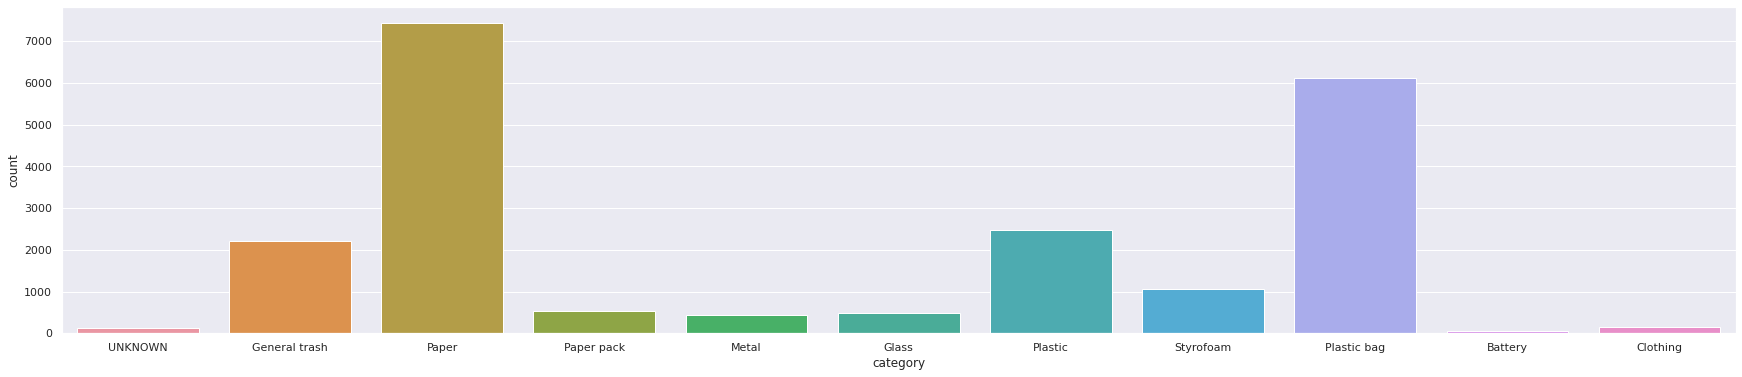

In [32]:
# 카테고리별 bbox개수 분포도
fig, ax1 = plt.subplots(1, 1, fcigsize = (30, 6))

sns.barplot(x = "category", y = "count",data = bbox_stat, ax = ax1)

In [33]:
category_name_list_all = ['UNKNOWN'] * class_bbox_count_list[0] + ['General trash'] * class_bbox_count_list[1] \
+ ['Paper'] * class_bbox_count_list[2] + ['Paper pack'] * class_bbox_count_list[3]\
+ ['Metal'] * class_bbox_count_list[4] + ['Glass'] * class_bbox_count_list[5]\
+ ['Plastic'] * class_bbox_count_list[6] + ['Styrofoam'] * class_bbox_count_list[7]\
+ ['Plastic bag'] * class_bbox_count_list[8] + ['Battery'] * class_bbox_count_list[9]\
+ ['Cloating'] * class_bbox_count_list[10]

In [34]:
assert len(category_name_list_all) == sum(class_bbox_count_list)

In [35]:
class_bbox_scale_list_all = []

# class_bbox_scale_list

for i in range(len(class_bbox_scale_list)):
    for scale in class_bbox_scale_list[i]:
        class_bbox_scale_list_all.append(scale)

In [36]:
bbox_stat = df(data= {"category" : category_name_list_all, "bbox_size" : class_bbox_scale_list_all},
               columns = ["category", "bbox_size"]
              )



bbox_stat.head()

,category,bbox_size
0,UNKNOWN,1689.61
1,UNKNOWN,5673.42
2,UNKNOWN,336.54
3,UNKNOWN,7972.02
4,UNKNOWN,281.16


<AxesSubplot:xlabel='bbox_size', ylabel='category'>

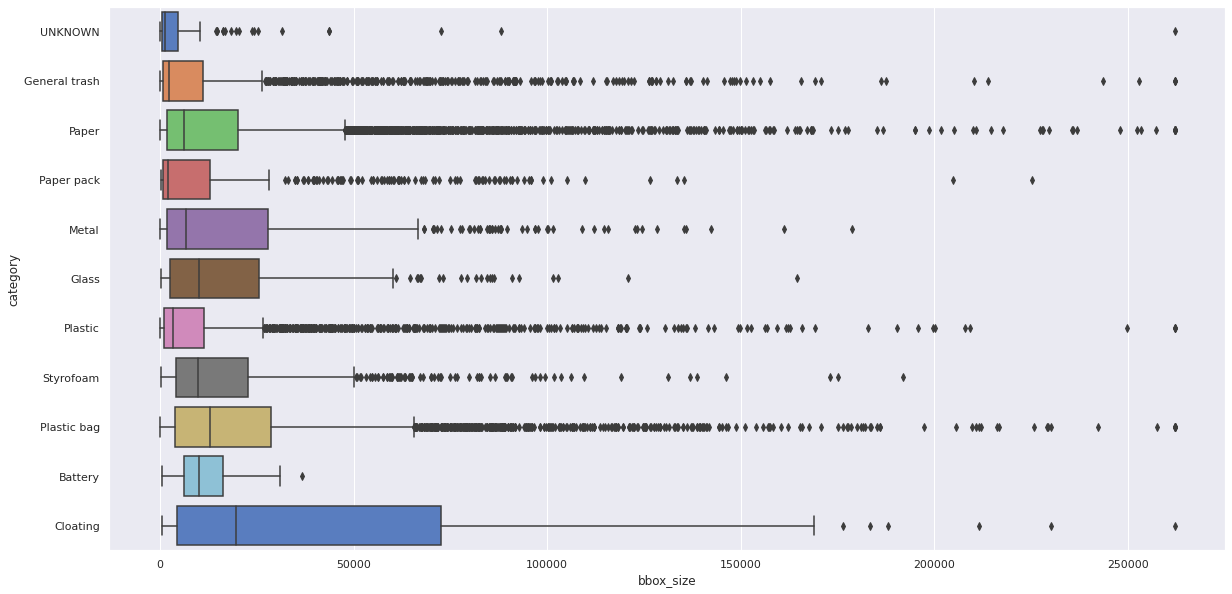

In [37]:
# 카테고리별 bbox크기 분포도
fig, ax1 = plt.subplots(1, 1, figsize = (20, 10))
sns.boxplot(x ="bbox_size", y="category", data = bbox_stat, palette = "muted", ax = ax1)

In [42]:
# unknown, Battery의 정확한 박스 크기 평균값 수치
unk_area_np_list = np.array(class_bbox_scale_list[0])
battery_area_np_list = np.array(class_bbox_scale_list[9])

In [44]:
print("unknown bbox 크기에 대한 정보")
print("count : ", len(unk_area_np_list))
print("mean of len : ", np.mean(unk_area_np_list))
print("std of len : ", np.std(unk_area_np_list))
print("max of len : ", np.max(unk_area_np_list))
print("min of len : ", np.min(unk_area_np_list))
print('제 1사분위 크기 : {}'.format(np.percentile(unk_area_np_list, 25)))
print('제 2사분위 크기 : {}'.format(np.percentile(unk_area_np_list, 50)))
print('제 3사분위 크기 : {}'.format(np.percentile(unk_area_np_list, 75)))

unknown bbox 크기에 대한 정보
count :  128
mean of len :  7612.195
std of len :  25675.44167551812
max of len :  261990.41999999998
min of len :  71.11999999999999
제 1사분위 크기 : 558.2
제 2사분위 크기 : 1291.115
제 3사분위 크기 : 4506.665


In [45]:
print("battery bbox 크기에 대한 정보")
print("count : ", len(battery_area_np_list))
print("mean of len : ", np.mean(battery_area_np_list))
print("std of len : ", np.std(battery_area_np_list))
print("max of len : ", np.max(battery_area_np_list))
print("min of len : ", np.min(battery_area_np_list))
print('제 1사분위 크기 : {}'.format(np.percentile(battery_area_np_list, 25)))
print('제 2사분위 크기 : {}'.format(np.percentile(battery_area_np_list, 50)))
print('제 3사분위 크기 : {}'.format(np.percentile(battery_area_np_list, 75)))

battery bbox 크기에 대한 정보
count :  50
mean of len :  11338.543
std of len :  7582.5089945010295
max of len :  36576.990000000005
min of len :  460.32
제 1사분위 크기 : 6148.0824999999995
제 2사분위 크기 : 10138.68
제 3사분위 크기 : 16216.7775


# bbox & Segmentation의 비율 계산

In [49]:
# 이미지를 순회하며 카테고리마다 박스의 사이즈가 얼마나 되는지 조사

# 클래스 마다 박스 크기 저장
class_bbox_segmentation_ratio_list = []

for _ in range(11):
    class_bbox_segmentation_ratio_list.append([])

for image_id in image_ids:
    
    # 이미지에 대한 정보를 가져오기
    image_infos = coco.loadImgs(image_id)[0]
    image_id = image_infos['id'] # 이미지 아이디를 가져옴
    
    # annotation정보를 가져오기
    ann_ids = coco.getAnnIds(imgIds=image_id)
    anns = coco.loadAnns(ann_ids)
    
    # 카테고리 정보 가져오기
    for ann in anns:
        category_id = ann['category_id']
        bbox_information = ann['bbox']
        bbox_area = bbox_information[2] * bbox_information[3]
        bbox_segmentation_ratio = ann['area'] / bbox_area
            
        class_bbox_segmentation_ratio_list[category_id].append(bbox_segmentation_ratio)

In [50]:
# 클래스마다의 bbox의 개수
class_bbox_count_list = []

for i in range(11):
    class_bbox_count_list.append(len(class_bbox_segmentation_ratio_list[i]))

In [51]:
class_bbox_count_list # 갯수 일치

[128, 2225, 7448, 527, 449, 488, 2472, 1074, 6114, 50, 141]

In [52]:
class_bbox_segmentation_ratio_list_all = []

for i in range(len(class_bbox_segmentation_ratio_list)):
    for scale in class_bbox_segmentation_ratio_list[i]:
        class_bbox_segmentation_ratio_list_all.append(scale)

In [53]:
bbox_seg_stat = df(data= {"category" : category_name_list_all, "bbox_seg_ratio" : class_bbox_segmentation_ratio_list_all},
               columns = ["category", "bbox_seg_ratio"]
              )



bbox_seg_stat.head()

,category,bbox_seg_ratio
0,UNKNOWN,0.605761
1,UNKNOWN,0.382573
2,UNKNOWN,0.601712
3,UNKNOWN,0.666519
4,UNKNOWN,0.435695


<AxesSubplot:xlabel='bbox_seg_ratio', ylabel='category'>

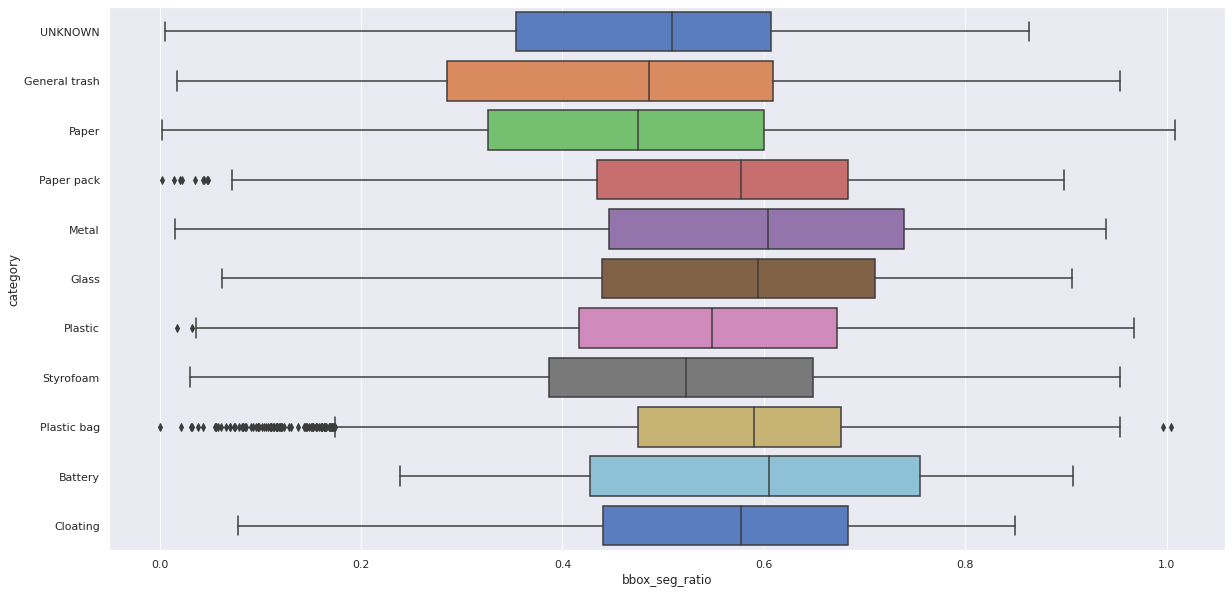

In [54]:
# 카테고리별 bbox크기 분포도
fig, ax1 = plt.subplots(1, 1, figsize = (20, 10))
sns.boxplot(x ="bbox_seg_ratio", y="category", data = bbox_seg_stat, palette = "muted", ax = ax1)

# coco Dataset 연습코드

In [22]:
image_id = coco.getImgIds(imgIds=0)

In [23]:
image_id

[0]

In [29]:
image_infos = coco.loadImgs(image_id)[0]

In [30]:
image_infos

{'license': 0,
 'url': None,
 'file_name': 'batch_01_vt/0002.jpg',
 'height': 512,
 'width': 512,
 'date_captured': None,
 'id': 0}

In [98]:
ann_ids = coco.getAnnIds(imgIds=9)

In [99]:
ann_ids # 이미지에 해당하는 어노테이이션 가져오기

[88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104]

In [33]:
anns = coco.loadAnns(ann_ids)

In [35]:
len(anns)

17

In [38]:
# anns[1] # annotation에 해당하는 정보 가져오기

In [41]:
cat_ids = coco.getCatIds()

In [42]:
cat_ids

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [43]:
cats = coco.loadCats(cat_ids)

In [44]:
len(cats)

11

In [45]:
cats[0]

{'id': 0, 'name': 'UNKNOWN', 'supercategory': 'UNKNOWN'}

In [46]:
%matplotlib inline
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab


In [47]:
coco = COCO('/opt/ml/input/data/val.json')

loading annotations into memory...
Done (t=1.19s)
creating index...
index created!


In [49]:
cat_ids = coco.getCatIds()
print(cat_ids)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [50]:
cats = coco.loadCats(cat_ids)

In [51]:
cats

[{'id': 0, 'name': 'UNKNOWN', 'supercategory': 'UNKNOWN'},
 {'id': 1, 'name': 'General trash', 'supercategory': 'General trash'},
 {'id': 2, 'name': 'Paper', 'supercategory': 'Paper'},
 {'id': 3, 'name': 'Paper pack', 'supercategory': 'Paper pack'},
 {'id': 4, 'name': 'Metal', 'supercategory': 'Metal'},
 {'id': 5, 'name': 'Glass', 'supercategory': 'Glass'},
 {'id': 6, 'name': 'Plastic', 'supercategory': 'Plastic'},
 {'id': 7, 'name': 'Styrofoam', 'supercategory': 'Styrofoam'},
 {'id': 8, 'name': 'Plastic bag', 'supercategory': 'Plastic bag'},
 {'id': 9, 'name': 'Battery', 'supercategory': 'Battery'},
 {'id': 10, 'name': 'Clothing', 'supercategory': 'Clothing'}]

In [52]:
nms = [cat['name'] for cat in cats]

In [53]:
print('COCO categories: \n{}\n'.format(' '.join(nms)))

COCO categories: 
UNKNOWN General trash Paper Paper pack Metal Glass Plastic Styrofoam Plastic bag Battery Clothing



In [54]:
nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(nms)))

COCO supercategories: 
Clothing Styrofoam Plastic bag Metal General trash Plastic Glass Battery UNKNOWN Paper Paper pack


In [123]:
catIds = coco.getCatIds(catNms = ['Battery'])

In [124]:
catIds

[9]

In [125]:
imgIds = coco.getImgIds(catIds= catIds)

In [126]:
imgIds

[19, 638]

In [127]:
image_infos1 = coco.loadImgs(imgIds[0])[0]
image_infos2 = coco.loadImgs(imgIds[1])[0]

In [128]:
image_infos1

{'license': 0,
 'url': None,
 'file_name': 'batch_01_vt/0149.jpg',
 'height': 512,
 'width': 512,
 'date_captured': None,
 'id': 19}

In [129]:
image_infos2

{'license': 0,
 'url': None,
 'file_name': 'batch_03/0862.jpg',
 'height': 512,
 'width': 512,
 'date_captured': None,
 'id': 638}

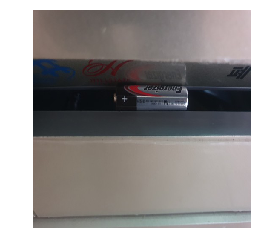

In [130]:
root_path = "/opt/ml/input/data/"

I = io.imread(root_path + image_infos1['file_name'])
plt.axis('off')
plt.imshow(I)
plt.show()

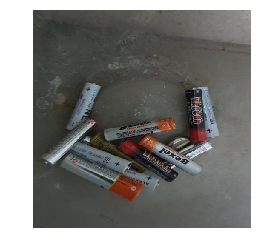

In [131]:
root_path = "/opt/ml/input/data/"

I = io.imread(root_path + image_infos2['file_name'])
plt.axis('off')
plt.imshow(I)
plt.show()

In [132]:
catIds = coco.getCatIds(catNms=['Battery']);
imgIds = coco.getImgIds(catIds=catIds);
print(catIds)
print(imgIds)

[9]
[19, 638]


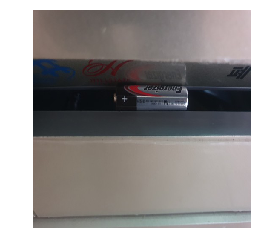

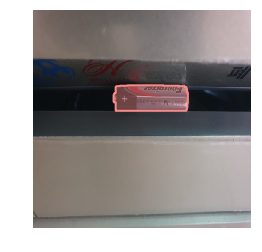

In [135]:
I = io.imread(root_path + image_infos1['file_name'])
plt.axis('off')
plt.imshow(I)
plt.show()

plt.imshow(I)
plt.axis('off')
annIds = coco.getAnnIds(imgIds=image_infos1['id'], catIds = catIds,iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

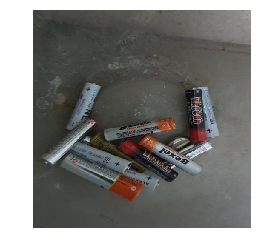

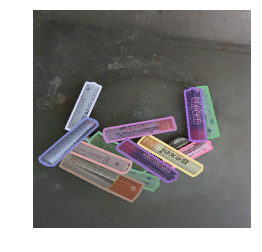

In [136]:
I = io.imread(root_path + image_infos2['file_name'])
plt.axis('off')
plt.imshow(I)
plt.show()

plt.imshow(I)
plt.axis('off')
annIds = coco.getAnnIds(imgIds=image_infos2['id'], catIds = catIds,iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

In [111]:
annIds = coco.getAnnIds(imgIds=19,iscrowd=None)

In [112]:
annIds

[88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104]

In [113]:
annIds = coco.getAnnIds(imgIds=9,catIds = [9],iscrowd=None)

In [114]:
annIds

[]

In [137]:
catIds = coco.getCatIds(catNms = ['UNKNOWN'])
catIds

[0]

In [139]:
imgIds = coco.getImgIds(catIds= catIds)
imgIds

[2,
 6,
 391,
 16,
 279,
 411,
 287,
 550,
 552,
 175,
 565,
 314,
 63,
 211,
 343,
 109,
 500,
 373,
 501]

In [151]:
image_infos_list = []

for i in range(10):
    image_infos_list.append(coco.loadImgs(imgIds[i])[0])


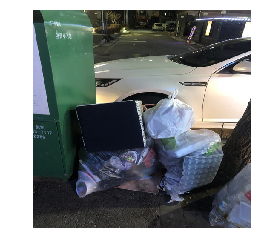

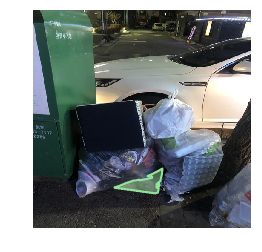

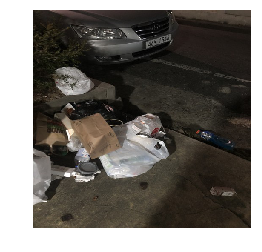

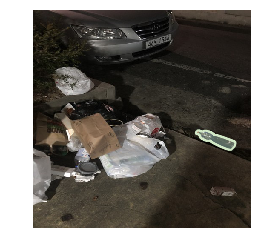

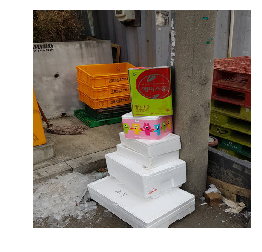

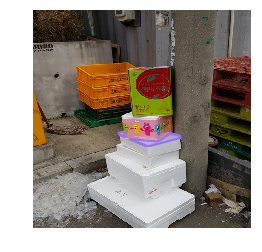

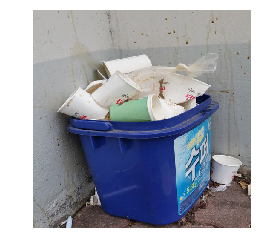

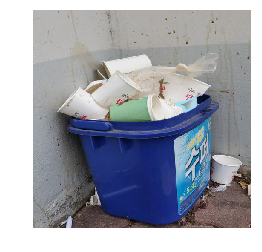

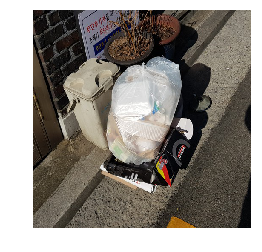

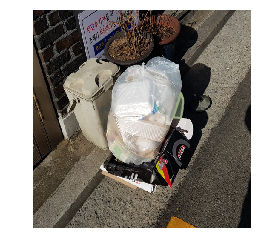

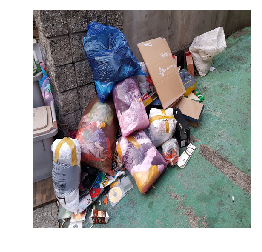

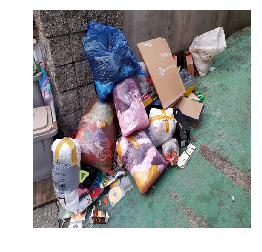

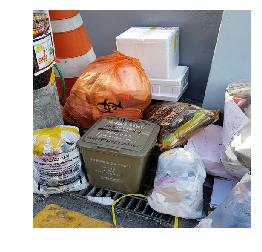

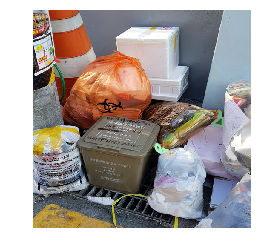

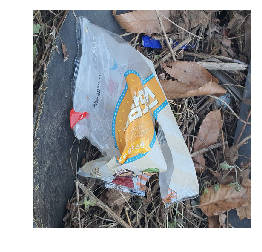

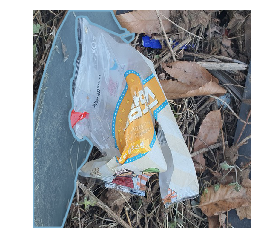

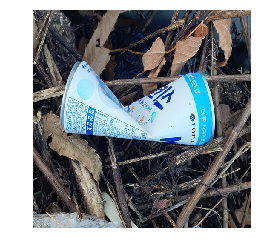

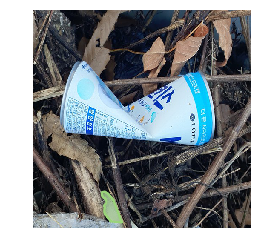

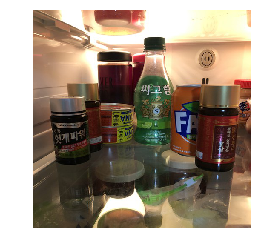

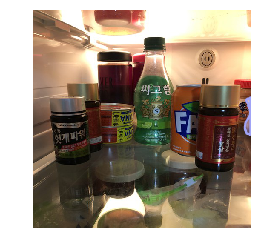

In [158]:

for i in range(10):
    I = io.imread(root_path + image_infos_list[i]['file_name'])
    plt.axis('off')
    plt.imshow(I)
    plt.show()

    plt.imshow(I)
    plt.axis('off')
    annIds = coco.getAnnIds(imgIds=image_infos_list[i]['id'], catIds = catIds,iscrowd=None)
    anns = coco.loadAnns(annIds)
    coco.showAnns(anns)
    plt.show()

# validation set 나누기

In [159]:
coco = COCO('/opt/ml/input/data/val.json')

loading annotations into memory...
Done (t=1.15s)
creating index...
index created!


In [161]:
help(coco)

Help on COCO in module pycocotools.coco object:

class COCO(builtins.object)
 |  COCO(annotation_file=None)
 |  
 |  Methods defined here:
 |  
 |  __init__(self, annotation_file=None)
 |      Constructor of Microsoft COCO helper class for reading and visualizing annotations.
 |      :param annotation_file (str): location of annotation file
 |      :param image_folder (str): location to the folder that hosts images.
 |      :return:
 |  
 |  annToMask(self, ann)
 |      Convert annotation which can be polygons, uncompressed RLE, or RLE to binary mask.
 |      :return: binary mask (numpy 2D array)
 |  
 |  annToRLE(self, ann)
 |      Convert annotation which can be polygons, uncompressed RLE to RLE.
 |      :return: binary mask (numpy 2D array)
 |  
 |  createIndex(self)
 |  
 |  download(self, tarDir=None, imgIds=[])
 |      Download COCO images from mscoco.org server.
 |      :param tarDir (str): COCO results directory name
 |             imgIds (list): images to be downloaded
 |     

In [172]:
temp = coco.info()

year: 2021
version: 1.0
description: Recycle Trash
contributor: Upstage
url: None
date_created: 2021-02-02 01:10:00


In [173]:
temp

In [174]:
print(temp)

None


In [175]:
import json
from sklearn.utils import Bunch

In [191]:
with open('/opt/ml/input/data/val.json') as f:
    hparams = json.load(f)

In [204]:
config = Bunch()
config.update(hparams)

In [205]:
config.info

{'year': 2021,
 'version': '1.0',
 'description': 'Recycle Trash',
 'contributor': 'Upstage',
 'url': None,
 'date_created': '2021-02-02 01:10:00'}

In [206]:
# config

In [207]:
type(config)

sklearn.utils.Bunch

In [208]:
type(config.info)

dict

In [209]:
new_json = {}
new_json['root'] = {}
new_json['root']['info'] = config.info

In [210]:
new_json

{'root': {'info': {'year': 2021,
   'version': '1.0',
   'description': 'Recycle Trash',
   'contributor': 'Upstage',
   'url': None,
   'date_created': '2021-02-02 01:10:00'}}}

In [211]:
# dictionary를 json으로 변환

# json_val = json.dumps(new_json)

In [212]:
# type(json_val)

In [219]:
with open("/opt/ml/test.json", 'w') as outfile:
    json.dump(json_val, outfile)

In [228]:
# # 방법1) json.dumps
# dic1 = {'ramyeon':{'a' : 1, 'b' : 2},'noodle':['ramyeon','ramen']}
# obj1 = json.dumps(dic1)

# print(type(obj1))""
# obj1

In [229]:
# with open('/opt/ml/test.json','w') as f:
#     json.dump(dic1,f)

In [246]:
dict1 = {'info' : config.info, 'licenses': config.licenses, 'categories' : config.categories}
obj1 = json.dumps(dict1)

print(type(obj1))
obj1

<class 'str'>


'{"info": {"year": 2021, "version": "1.0", "description": "Recycle Trash", "contributor": "Upstage", "url": null, "date_created": "2021-02-02 01:10:00"}, "licenses": [{"id": 0, "name": "CC BY 4.0", "url": "https://creativecommons.org/licenses/by/4.0/deed.ast"}], "categories": [{"id": 0, "name": "UNKNOWN", "supercategory": "UNKNOWN"}, {"id": 1, "name": "General trash", "supercategory": "General trash"}, {"id": 2, "name": "Paper", "supercategory": "Paper"}, {"id": 3, "name": "Paper pack", "supercategory": "Paper pack"}, {"id": 4, "name": "Metal", "supercategory": "Metal"}, {"id": 5, "name": "Glass", "supercategory": "Glass"}, {"id": 6, "name": "Plastic", "supercategory": "Plastic"}, {"id": 7, "name": "Styrofoam", "supercategory": "Styrofoam"}, {"id": 8, "name": "Plastic bag", "supercategory": "Plastic bag"}, {"id": 9, "name": "Battery", "supercategory": "Battery"}, {"id": 10, "name": "Clothing", "supercategory": "Clothing"}]}'

In [247]:
with open('/opt/ml/test.json','w') as f:
    json.dump(dict1,f)

In [248]:
cat_ids = coco.getCatIds()
print(cat_ids)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


In [249]:
cats = coco.loadCats(cat_ids)

In [251]:
cats

[{'id': 0, 'name': 'UNKNOWN', 'supercategory': 'UNKNOWN'},
 {'id': 1, 'name': 'General trash', 'supercategory': 'General trash'},
 {'id': 2, 'name': 'Paper', 'supercategory': 'Paper'},
 {'id': 3, 'name': 'Paper pack', 'supercategory': 'Paper pack'},
 {'id': 4, 'name': 'Metal', 'supercategory': 'Metal'},
 {'id': 5, 'name': 'Glass', 'supercategory': 'Glass'},
 {'id': 6, 'name': 'Plastic', 'supercategory': 'Plastic'},
 {'id': 7, 'name': 'Styrofoam', 'supercategory': 'Styrofoam'},
 {'id': 8, 'name': 'Plastic bag', 'supercategory': 'Plastic bag'},
 {'id': 9, 'name': 'Battery', 'supercategory': 'Battery'},
 {'id': 10, 'name': 'Clothing', 'supercategory': 'Clothing'}]

In [252]:
nms = [cat['name'] for cat in cats]

In [253]:
nms

['UNKNOWN',
 'General trash',
 'Paper',
 'Paper pack',
 'Metal',
 'Glass',
 'Plastic',
 'Styrofoam',
 'Plastic bag',
 'Battery',
 'Clothing']